<a href="https://colab.research.google.com/github/alla-g/NN_methods_hw/blob/main/hw2/hw2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchmetrics

     |████████████████████████████████| 329 kB 11.1 MB/s 


In [3]:
pip install slovnet

     |████████████████████████████████| 49 kB 4.5 MB/s 


In [67]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 8.2 MB 12.8 MB/s 


In [68]:
import re
import nltk
import pickle
import pymorphy2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from navec import Navec
from random import sample
from pprint import pprint
from string import punctuation
from collections import Counter

from slovnet.model.emb import NavecEmbedding
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1

morph = pymorphy2.MorphAnalyzer()
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Классифицируем твиты



### Скачивание и подготовка данных

In [5]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv

--2021-11-24 15:21:03--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-24 15:21:04--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc058f04cd8d5a671c9def067aca.dl.dropboxusercontent.com/cd/0/inline/BalWgSEwnUIthIXsTTVK-hCVMfoia217knOUPf5QB3Cp3rzqtNpDWpWbUyUEiJ8Ez42DC0C1nmI1p9RULyvcqJfM9Q2_GKlxOe6QxJNNEqX8augZJNuR_64E5n4xpVY9x2-AJYqVAJna75oI5R4ZV2Ak/file# [following]
--2021-11-24 15:21:04--  https://uc058f04cd8d5a671c9def067aca.dl.dropboxusercontent.com/cd/0/inline/BalWgSEwnUIthIXsTTVK-hCVMfoia217knOUPf5QB3Cp3rzqtNpDWpWbUyUEiJ8Ez42DC0C1nmI1p9RULyvcqJfM9

In [6]:
negative = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, usecols=[3,4], names=['text','label'])
positive = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None, usecols=[3,4], names=['text','label'])
data = pd.concat([negative, positive], ignore_index=True)

In [7]:
data['label'].replace(-1, 0, inplace=True)

In [8]:
data.head(5)

,text,label
0,на работе был полный пиддес :| и так каждое за...,0
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",0
2,@elina_4post как говорят обещаного три года жд...,0
3,"Желаю хорошего полёта и удачной посадки,я буду...",0
4,"Обновил за каким-то лешим surf, теперь не рабо...",0


In [9]:
data.label.unique()

array([0, 1])

In [10]:
train_data, val_data = train_test_split(data, test_size=0.2)

In [11]:
train_data[train_data.label == 1].shape[0] /train_data.shape[0]

0.5065934853168895

In [12]:
train_data.head(5)

,text,label
136028,RT @Creative_Link: Дождались! Официальный трей...,1
193926,Вот так мы и прощаемся каждый день:D http://t....,1
176024,"RT @MCRGWLD: @funnyhoorse ХАХА,ДЫ ЧЕ ТЫ...ВСЕ ...",1
41256,@audrey_zoe ой не.. не люблю я сырое мясо..фу ...,0
163552,"В свет вышел #МачетеУбивает, щас буду кушать и...",1


#### Добавление препроцессинга

In [13]:
# from https://habr.com/ru/company/vk/blog/417767/
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [14]:
data['preproc_text'] = data['text'].apply(preprocess_text)

In [15]:
# проверить, что всё верно
data.text[444], data.preproc_text[444]

('@HeiligSein483 блин, у меня было такое же :( а купить такие же ?',
 'USER блин у меня было такое же а купить такие же')

In [16]:
proc_train_data, proc_val_data = train_test_split(data[['preproc_text', 'label']], test_size=0.2)

### CNN по словам

Теперь нам нужно собрать все слова в словарь. Лучше сразу посчитать количество упоминаний, чтобы отсеять самые редкие.

In [17]:
len(data['text'])

226834

In [18]:
vocab = Counter()
for text in data['text']:
    vocab.update(word_tokenize(text))
print('всего уникальных слов:', len(vocab))

всего уникальных слов: 359652


In [19]:
vocab

Counter({'на': 35715,
         'работе': 592,
         'был': 2627,
         'полный': 173,
         'пиддес': 1,
         ':': 177666,
         '|': 1062,
         'и': 54916,
         'так': 16739,
         'каждое': 68,
         'закрытие': 4,
         'месяца': 304,
         ',': 188295,
         'я': 52506,
         'же': 9606,
         'свихнусь': 5,
         'D': 16552,
         'Коллеги': 11,
         'сидят': 106,
         'рубятся': 3,
         'в': 52853,
         'Urban': 4,
         'terror': 3,
         'а': 26589,
         'из-за': 1181,
         'долбанной': 4,
         'винды': 12,
         'не': 69267,
         'могу': 3946,
         '(': 212404,
         '@': 149978,
         'elina_4post': 1,
         'как': 18141,
         'говорят': 596,
         'обещаного': 1,
         'три': 719,
         'года': 1356,
         'ждут': 124,
         '...': 28773,
         'Желаю': 161,
         'хорошего': 381,
         'полёта': 4,
         'удачной': 31,
         'посадки': 5

Я оставляю порог в 5, думаю, его должно быть достаточно, чтобы отсеять всякие упоминания юзернеймов и нечастотные опечатки/эрративы

In [20]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

уникальных слов, встретившихся больше 5 раз: 33670


In [21]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [22]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [23]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE


device(type='cuda')

#### Dataset & DataLoader

In [55]:
class TweetDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['label'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = word_tokenize(self.dataset[index])
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

Итераторы по данным для трейна и теста

In [56]:
train_dataset = TweetDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [57]:
batch = next(iter(train_iterator))

In [58]:
batch[0].shape

torch.Size([1024, 48])

In [59]:
[id2word[int(i)] for i in batch[0][0]]

['@',
 'LARISA3007',
 'Оу',
 ',',
 'спасибо',
 ',',
 'приятно',
 ')',
 'И',
 'тебе',
 'отличного',
 'новогоднего',
 'настроения',
 ')',
 ')',
 ')',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [60]:
batch[1][0]

tensor([1.], device='cuda:0')

In [61]:
val_dataset = TweetDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [62]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 70])

#### CNN model

In [33]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concated = nn.Conv1d(in_channels=180, out_channels=60, kernel_size=2, padding='same')
        self.hidden = nn.Linear(in_features=60, out_features=1)
        # self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, sent):
        #batch_size x seq_len
        embedded = self.embedding(sent) # ✔
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2) # ✔
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.bigrams(embedded) # ✔
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.trigrams(embedded) # ✔
        #batch_size x filter_count3 x seq_len*
        
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1) # ✔
        # batch_size x (filter_count2 + filter_count3) x seq_len
        feature_map_concat = self.concated(concat) # ✔
        # batch_size x filter_concat x seq_len
        pooling = feature_map_concat.max(2)[0] # ✔
        # batch_size x filter_concat)
        logits = self.hidden(pooling) # ✔
        logits = self.out(logits) # ✔
        return logits
      
        
    

In [64]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[  995, 18995,  9755,  ...,     0,     0,     0],
        [32667,  5535, 33650,  ...,     0,     0,     0],
        [  995, 17239, 10007,  ...,     0,     0,     0],
        ...,
        [ 4955, 10184, 25910,  ...,     0,     0,     0],
        [ 7249,   995, 10184,  ...,     0,     0,     0],
        [  995, 25756, 27748,  ...,     0,     0,     0]])


In [65]:
y

tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]])

In [66]:
model = CNN(len(id2word), 8)
output = model(batch)
print(output)

tensor([[0.5522],
        [0.5256],
        [0.5465],
        ...,
        [0.6029],
        [0.6142],
        [0.5390]], grad_fn=<SigmoidBackward0>)


In [67]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.6938, grad_fn=<BinaryCrossEntropyBackward0>)

In [68]:
f1(output, y.long())

tensor(0.6728)

#### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [34]:
def train(model, iterator, optimizer, criterion, metric):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    epoch_metric = 0
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric
        if not (i + 1) % 20:
            print(f'Train loss: {loss.item()}, Train f1: {batch_metric}')
            #print(f'Train loss: {epoch_loss/i}, Train f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [35]:
def evaluate(model, iterator, criterion, metric):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % 20:
              print(f'Val loss: {loss.item()}, Val f1: {batch_metric}')
              #print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

Инициализируем модель, задаем оптимизатор и функцию потерь

In [71]:
model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

#### Запуск обучения!

In [72]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

# по пробам, уже на 15-20 эпохе точность достигает 0,999
for i in range(20):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, metric=f1)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, metric=f1)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 0
Training...
Train loss: 0.33757084608078003, Train f1: 0.9014634490013123
Train loss: 0.18260258436203003, Train f1: 0.9420561194419861
Train loss: 0.15789590775966644, Train f1: 0.9448668956756592
Train loss: 0.10068300366401672, Train f1: 0.9746001362800598
Train loss: 0.1180788204073906, Train f1: 0.9644970893859863
Train loss: 0.07700455188751221, Train f1: 0.9757517576217651
Train loss: 0.09461649507284164, Train f1: 0.9737827777862549
Train loss: 0.08399754017591476, Train f1: 0.9718574285507202

Validating...
Val loss: 0.051621466875076294, Val f1: 0.9845261573791504
Val loss: 0.10239769518375397, Val f1: 0.9655813574790955

starting Epoch 1
Training...
Train loss: 0.08718040585517883, Train f1: 0.9666349291801453
Train loss: 0.06330204010009766, Train f1: 0.9771143794059753
Train loss: 0.0705520510673523, Train f1: 0.9757462739944458
Train loss: 0.04814045876264572, Train f1: 0.9814433455467224
Train loss: 0.05766376107931137, Train f1: 0.9753208160400391
Trai

In [73]:
torch.save(model, 'colab_model_1.pt')

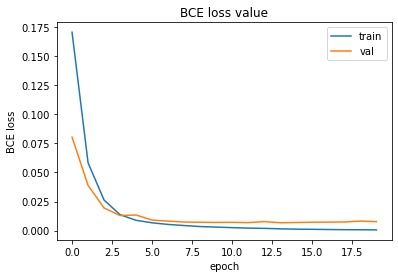

In [74]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

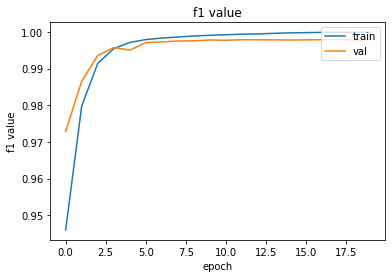

In [75]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [36]:
def predict(model, iterator, id2word):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [77]:
# model = torch.load('colab_model_1.pt')

In [131]:
fp, fn, tp, tn = predict(model, val_iterator, id2word)

#### Анализ предсказаний

In [132]:
len(fp + fn + tp + tn)

45367

In [133]:
accuracy = len(tp + tn) / len(fp + fn + tp + tn)
precision = len(tp) / (len(tp) + len(fp))
recall= len(tp) / (len(tp) + len(fn))

In [134]:
accuracy, precision, recall

(0.9978398395309366, 0.99777739039484, 0.9979513555923634)

Все три метрики со значениями выше 0.99, что уже довольно хорошо. При этом нет значительной разницы между точностью и полнотой, значит, модель не склонна ошибаться в какую-то одну сторону. Этому способствовало то, что наш корпус оказался почти идеально сбалансирован.

In [135]:
f1s_eval[-1]

tensor(0.9979, device='cuda:0')

In [136]:
f1s[-1]

tensor(0.9999, device='cuda:0')

Однако даже с такими высокими значениями метрик ошибки всё равно были допущены. Давайте посмотрим:

In [137]:
len(fp)

51

In [138]:
len(fn)

47

In [149]:
print('Предсказали хорошую тональность, а она на самом деле плохая:\n')
# несколько примеров из всех мест списка
for tweet in fp[::5]:
    print(tweet)

Предсказали хорошую тональность, а она на самом деле плохая:

Ненавижу писать с телефону , нервы не , пальцы не ( Не мое это : D
@ o_OlyaO__o звучит
RT @ Heart_Tardis : @ Я прочитала : из всех
RT @ : @ в придачу с :
Почти 13 лет ( Жалко жалко , но такой специалист долго без работы не останется
( — тот воин , с кем вам придется драться , огромный , мне таких не приходилось видеть . я бы с ним драться . — и потому будеш
( блин не умеешь ты готовить корова !
Шоколад снимает пресс RT @ : `` @ : Шоколад снимает стресс . '' не уверена : |
@ Namiko_o Будет ли нам картина ? : з Вижу , день прошел не так уж дурно , как мог бы . Это мысль , несомненно , греет мою душу . :3
( правительства россии и правительства с имени д
@ ахаха ты бы видела кто мне это написал ; D


На мой взгляд, большинство предложений действительно неоднозначны по разметке. Возможно, в предобработке были удалены какие-то редкие слова или сочетания символов, которые могли бы лучше выразить эмоции. И сама эталонная разметка тоже вызывает вопросы, например, почему это предложение негативное?

In [85]:
data[data['text'].str.contains('ахаха ты бы видела кто мне это написал')]  

,text,label,preproc_text
43890,@katya_katyaO_o ахаха ты бы видела кто мне это...,0,USER ахаха ты бы видела кто мне это написал d


In [150]:
print('Предсказали плохую тональность, а она на самом деле хорошая:\n')
# несколько примеров из всех мест списка
for tweet in fn[::5]:
    print(tweet)

Предсказали плохую тональность, а она на самом деле хорошая:

2 место в и в детском станете это же круто мы : все супер : как скотина , пришла и уснула сразу же сегодня
мда вообщем я пошла в , надеюсь по тв какой нибудь фильмец будет , и интересный . крч . заранее спокойной ночи ,
RT @ _unknown_nick_ : бесится . Что вот он бесится ? :
@ : . Сегодня фильм в дк есть ? Да ?
@ karrimov НУ СКОЛЬКО МОЖНО БЫТЬ ТАКИМ ! ! Но за в твоих глазах я прощу тебе
этим просто не http :
Охохо приехала моя любимая : ******* http :
@ ну это же капеец : еще не знаешь что вчера у нас на было : В
@ первый раз услышал . Мне очень
RT @ : @ ахах , чувак , что с тобой ? Тебя упороло ? : мне спать в ?


Та же ситуация и с ложнонегативными твитами, не все из них даже для человека очевидно положительные

В целом, кроме сотни сомнительных случаев, у этой модели получилась очень ооочень высокая точность. Улучшать такое почти бессмысленно и невозможно, поэтому сначала "ухудшим" работу удалением пунктуации и прочим препроцессингом 

#### То же самое, но с препроцессингом
Здесь же я сразу уменьшу количество эпох, потому что колаб отключил мне гпу. Все последующие улучшения будут сравниваться с этой моделью на 10 эпохах

In [113]:
data.head(5)

,text,label,preproc_text
0,на работе был полный пиддес :| и так каждое за...,0,на работе был полный пиддес и так каждое закры...
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,коллеги сидят рубятся в urban terror а я из за...
2,@elina_4post как говорят обещаного три года жд...,0,USER как говорят обещаного три года ждут
3,"Желаю хорошего полёта и удачной посадки,я буду...",0,желаю хорошего полета и удачной посадки я буду...
4,"Обновил за каким-то лешим surf, теперь не рабо...",0,обновил за каким то лешим surf теперь не работ...


In [114]:
proc_vocab = Counter()
for text in data['preproc_text']:
    proc_vocab.update(word_tokenize(text))
print('всего уникальных слов:', len(proc_vocab))

всего уникальных слов: 180371


In [115]:
filtered_proc_vocab = set()

for word in proc_vocab:
    if proc_vocab[word] > 5:
        filtered_proc_vocab.add(word)
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_proc_vocab))

уникальных слов, встретившихся больше 5 раз: 28141


In [116]:
proc_word2id = {'PAD':0}

for word in filtered_proc_vocab:
    proc_word2id[word] = len(proc_word2id)

proc_id2word = {i:word for word, i in proc_word2id.items()}

In [25]:
class ProcTweetDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['preproc_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['label'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = word_tokenize(self.dataset[index])
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [28]:
proc_train_dataset = ProcTweetDataset(proc_train_data, proc_word2id, DEVICE)
proc_train_sampler = RandomSampler(proc_train_dataset)
proc_train_iterator = DataLoader(proc_train_dataset, collate_fn = proc_train_dataset.collate_fn, sampler=proc_train_sampler, batch_size=1024)

In [29]:
batch = next(iter(proc_train_iterator))

In [31]:
[proc_id2word[int(i)] for i in batch[0][0]]

['опять',
 'с',
 'работы',
 'кто',
 'то',
 'обогреватель',
 'унес',
 'домой',
 'себе',
 'да',
 'что',
 'ж',
 'это',
 'такое',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [32]:
proc_val_dataset = ProcTweetDataset(proc_val_data, proc_word2id, DEVICE)
proc_val_sampler = SequentialSampler(proc_val_dataset)
proc_val_iterator = DataLoader(proc_val_dataset, collate_fn = proc_val_dataset.collate_fn, sampler=proc_val_sampler, batch_size=1024)

Инициализируем модель, задаем оптимизатор и функцию потерь

In [68]:
proc_model = CNN(len(proc_word2id), 8)
optimizer = optim.Adam(proc_model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
proc_model = proc_model.to(DEVICE)
criterion = criterion.to(DEVICE)

Запуск обучения

In [69]:
proc_losses = []
proc_losses_eval = []
proc_f1s = []
proc_f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(proc_model, proc_train_iterator, optimizer, criterion, metric=f1)
    proc_losses.append(epoch_loss)
    proc_f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(proc_model, proc_val_iterator, criterion, metric=f1)
    proc_losses_eval.append(epoch_loss_on_test)
    proc_f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train loss: 0.664557695388794, Train f1: 0.6055396199226379
Train loss: 0.6568320393562317, Train f1: 0.6566164493560791
Train loss: 0.6424357295036316, Train f1: 0.6476014852523804
Train loss: 0.6430798768997192, Train f1: 0.6520547866821289
Train loss: 0.634396493434906, Train f1: 0.6624203324317932
Train loss: 0.6252267956733704, Train f1: 0.6385068893432617
Train loss: 0.6227544546127319, Train f1: 0.6367265582084656
Train loss: 0.6131086945533752, Train f1: 0.6788511276245117

Validating...
Val loss: 0.617708146572113, Val f1: 0.6744394898414612
Val loss: 0.6114677786827087, Val f1: 0.6629934906959534

starting Epoch 2
Training...
Train loss: 0.6052495837211609, Train f1: 0.6692087650299072
Train loss: 0.5972530841827393, Train f1: 0.6608357429504395
Train loss: 0.6148461699485779, Train f1: 0.6216506361961365
Train loss: 0.5922719836235046, Train f1: 0.6794995665550232
Train loss: 0.5950621962547302, Train f1: 0.6714140176773071
Train loss: 0.5882591

In [70]:
torch.save(proc_model, 'colab_proc_model_1.pt')

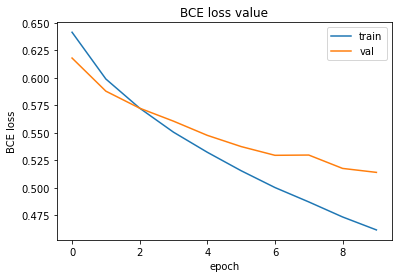

In [71]:
plt.plot(proc_losses)
plt.plot(proc_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

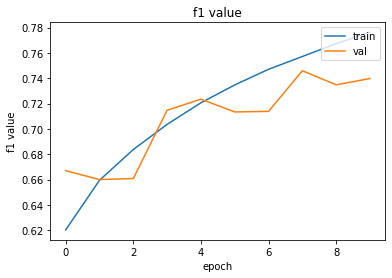

In [72]:
plt.plot(proc_f1s)
plt.plot(proc_f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [80]:
# model = torch.load('colab_model_1.pt')

In [73]:
proc_fp, proc_fn, proc_tp, proc_tn = predict(proc_model, proc_val_iterator, proc_id2word)

#### Анализ предсказаний

In [81]:
len(proc_fp + proc_fn + proc_tp + proc_tn)

45367

In [82]:
proc_accuracy = len(proc_tp + proc_tn) / len(proc_fp + proc_fn + proc_tp + proc_tn)
proc_precision = len(proc_tp) / (len(proc_tp) + len(proc_fp))
proc_recall= len(proc_tp) / (len(proc_tp) + len(proc_fn))

In [83]:
proc_accuracy, proc_precision, proc_recall

(0.7394581964864329, 0.7504028648164727, 0.7286161335187761)

Без пунктуации модель ожидаемо стала справляться хуже. Точность чуть выше, чем полнота, но в целом можно сказать, что модель не отдаёт предпочтения какому-то одному классу. Это происходит в том числе благодаря почти идеальной сбалансированности корпуса

In [85]:
len(proc_fp)

5576

А на этом моменте у меня отключился гпу, все переменные и файлы сбросились, модель не сохранилась и я пошла обучать её ещё раз, но без гпу

In [86]:
len(proc_fn)

6244

In [87]:
print('Предсказали хорошую тональность, а она на самом деле плохая:\n')
# несколько примеров из всех мест списка
for tweet in sample(proc_fp, 20):
    print(tweet)

Предсказали хорошую тональность, а она на самом деле плохая:

еду на рынок за а потом в шк вызвали репетировать
поднимите мне настроение кто URL
rt USER новости в вк читать интересней чем беда
USER локомотив арсенал URL стадион сейчас такого не увидишь
USER хочу тебя не кого из звезд в вк нет там может быть страничка и все
теперь вы меня не можете анфолловить иначе я скажу что вы
надоело все вся эта жизнь хочеться набрать команду из 5 самых важных и дорогих мне людей и свалить на необитаемый остров
USER да а мне надо англ вообще на 5 написать ко всему еще
занимаюсь переводами пока нет компа для игр
USER USER мы пока ничего не знаем
на что тебе не хватает времени на время с друзьями URL
rt USER р пользуясь случаем хочу также сказать что никогда не ни в одной сети USER
нужная актуальная дискуссия но как то ирина анатольевна себя в ряды корпуса pr URL
rt USER девушки мама вас не учила что чужие вещи брать нельзя ну зачем же наш город URL иваново во
USER ибо ты сказала что если телефон пол

На мой взгляд, нельзя винить модель за то, что она не поняла, что эти твиты негативные.. После предобработки в этих твитах осталось очень мало информации, и я уверена, что и человек бы не смог их классифицировать верно. Только несколько твитов отсюда, на мой взгляд, можно действительно засчитать за ошибку, например:
* *поднимите мне настроение кто URL*
* *надоело все вся эта жизнь хочеться набрать команду из 5 самых важных и дорогих мне людей и свалить на необитаемый остров*
* *USER USER мы пока ничего не знаем*

In [88]:
print('Предсказали плохую тональность, а она на самом деле хорошая:\n')
# несколько примеров из всех мест списка
for tweet in sample(proc_fn, 20):
    print(tweet)

Предсказали плохую тональность, а она на самом деле хорошая:

эй идиот не плачь все равно ничего уже не изменится
USER USER смотрите чтоб вас снегом не занесло ибо у меня метель а то придется за вами посылать
вот твоего отца он вам понадобится для стола o teamfollowback
с утра я думала что день будет и ничего не изменится но я ошибалась он еще столько классного за день
сижу значит в маке а тут слышу русскую речь боже мой у меня глаза раза в 2
USER ты морковку в кофе или я чего то в жизни не понимаю
USER что ж вы всю интригу на
рассказала монолог ужасно но мне 9 поставили
ахахахах хахахахаха это блять что вообще такое меня смущает эта хрень URL
USER хочешь я с тобой русским
все я дома буду заниматься буду диски красить и учиться менять
rt USER мне настолько грустно что USER кажется веселой лол
бля даже в клубе есть я нашла этого илью
USER оу з если к 2 не будет письма я напишу тебе а о чем тебе написать
rt USER USER есть такие люди которые судьба
жду принца на белом коне видимо ты предс

С ложноотрицательными предсказаниями почти та же ситуация. Я бы сказала, что только эти твиты - на самом деле грубые ошибки:
* *с утра я думала что день будет и ничего не изменится но я ошибалась он еще столько классного за день*
* *сижу значит в маке а тут слышу русскую речь боже мой у меня глаза раза в 2*
* *рассказала монолог ужасно но мне 9 поставили*

Здесь сразу надо сделать заметку про сам корпус. Как написано в статье про него, он изначально собирался и размечался не вручную, а на основании словаря "положительных" и "отрицательных" смайликов.   
Во-первых, отсутствие ручной разметки сразу делает данные менее точными и консистентными, что может запутывать модель.  
Во-вторых, кажется, что смысл твитов, собранных по смайликами, будет скорее содержаться в этих самых смайликах, чем в словах. Убирая эти смайлы, мы получаем текст, который даже человек не всегда может однозначно классифицировать.  
В-третьих, известно, что смайлики в неформальной письменной речи могут быть маркерами сарказма, и автоматический парсер, опираясь только на них, может неверно определить класс текста. Например, твит *эй идиот не плачь все равно ничего уже не изменится* в эталоне помечен как положительный. Скорее всего, это сарказм и там в конце был весёлый смайлик, из-за которого твит попал в положительный класс. А когда модель (да и человек) видит это предложение без пунктуации, то разумно определяет его как негативное. И это только один пример, попавший в очень маленький сэмпл. Внутри корпуса таких путающих данных намного больше, и, по моим ощущениям, модель скорее ошибается в них, чем в более однозначных примерах.

#### Улучшение модели
Общие идеи улучшений:
* добавить дропаут
* изменить размер фильтров
* добавить нелинейность
* попробовать другой оптимайзер
* поменять лёрнинг рейт



##### Дропаут

In [46]:
class CNN_drop(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concated = nn.Conv1d(in_channels=180, out_channels=60, kernel_size=2, padding='same')
        self.hidden = nn.Linear(in_features=60, out_features=1)
        self.dropout = nn.Dropout(p=0.4)
        self.out = nn.Sigmoid()

    def forward(self, sent):
        #batch_size x seq_len
        embedded = self.embedding(sent) # ✔
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2) # ✔
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.bigrams(embedded)) # ✔
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.trigrams(embedded)) # ✔
        #batch_size x filter_count3 x seq_len*
        
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1) # ✔
        # batch_size x (filter_count2 + filter_count3) x seq_len
        feature_map_concat = self.concated(concat) # ✔
        # batch_size x filter_concat x seq_len
        pooling = feature_map_concat.max(2)[0] # ✔
        # batch_size x filter_concat)
        logits = self.hidden(pooling) # ✔
        logits = self.out(logits) # ✔
        return logits
      
        
    

In [47]:
proc_drop_model = CNN_drop(len(proc_word2id), 8)
optimizer = optim.Adam(proc_drop_model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
proc_drop_model = proc_drop_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [48]:
proc_losses = []
proc_losses_eval = []
proc_f1s = []
proc_f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(proc_drop_model, proc_train_iterator, optimizer, criterion, metric=f1)
    proc_losses.append(epoch_loss)
    proc_f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(proc_drop_model, proc_val_iterator, criterion, metric=f1)
    proc_losses_eval.append(epoch_loss_on_test)
    proc_f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train loss: 0.6678961515426636, Train f1: 0.5614035129547119
Train loss: 0.6708136200904846, Train f1: 0.5805169343948364
Train loss: 0.6474930047988892, Train f1: 0.5931321382522583
Train loss: 0.6600193977355957, Train f1: 0.5873015522956848
Train loss: 0.6305341124534607, Train f1: 0.6135693192481995
Train loss: 0.6429764032363892, Train f1: 0.6480836272239685
Train loss: 0.6477515697479248, Train f1: 0.6473779678344727
Train loss: 0.6287651062011719, Train f1: 0.6174089312553406

Validating...
Val loss: 0.6221636533737183, Val f1: 0.6785110235214233
Val loss: 0.6134932637214661, Val f1: 0.6931217312812805

starting Epoch 2
Training...
Train loss: 0.6351068615913391, Train f1: 0.6063719987869263
Train loss: 0.6124423146247864, Train f1: 0.6323232650756836
Train loss: 0.609627366065979, Train f1: 0.6685032248497009
Train loss: 0.6113430261611938, Train f1: 0.6358866691589355
Train loss: 0.6128882169723511, Train f1: 0.6525911688804626
Train loss: 0.60660

In [49]:
torch.save(proc_model, 'colab_proc_drop_model_1.pt')

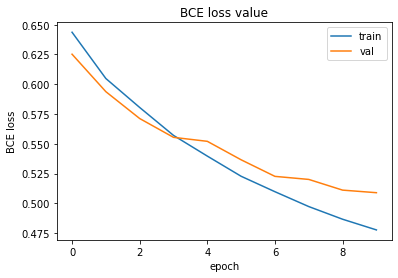

In [50]:
plt.plot(proc_losses)
plt.plot(proc_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

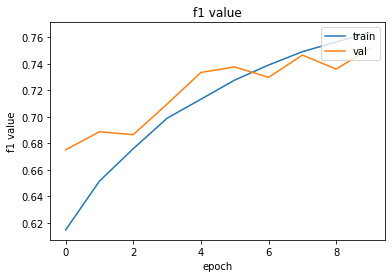

In [51]:
plt.plot(proc_f1s)
plt.plot(proc_f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [52]:
proc_fp, proc_fn, proc_tp, proc_tn = predict(proc_drop_model, proc_val_iterator, proc_id2word)

In [53]:
len(proc_fp + proc_fn + proc_tp + proc_tn)

45367

In [54]:
proc_drop_accuracy = len(proc_tp + proc_tn) / len(proc_fp + proc_fn + proc_tp + proc_tn)
proc_drop_precision = len(proc_tp) / (len(proc_tp) + len(proc_fp))
proc_drop_recall= len(proc_tp) / (len(proc_tp) + len(proc_fn))

In [89]:
# было
proc_accuracy, proc_precision, proc_recall

(0.7394581964864329, 0.7504028648164727, 0.7286161335187761)

In [55]:
# стало
proc_drop_accuracy, proc_drop_precision, proc_drop_recall

(0.7407366588048582, 0.7308860967397552, 0.7736439499304589)

Успех! Доля верных ответов выросла, полнота выросла ещё больше, правда точность упала  
Попробую к дропауту добавить ещё что-нибудь

##### Оптимайзер
Теперь всё то же самое, но с другим оптимайзером. Хоть Адам считается лучшим, вдруг тут сработает другой?

In [94]:
proc_drop_opt_model = CNN_drop(len(proc_word2id), 8)
optimizer = optim.RMSprop(proc_drop_opt_model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
proc_drop_opt_model = proc_drop_opt_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [95]:
proc_losses = []
proc_losses_eval = []
proc_f1s = []
proc_f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(proc_drop_opt_model, proc_train_iterator, optimizer, criterion, metric=f1)
    proc_losses.append(epoch_loss)
    proc_f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(proc_drop_opt_model, proc_val_iterator, criterion, metric=f1)
    proc_losses_eval.append(epoch_loss_on_test)
    proc_f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train loss: 0.660294771194458, Train f1: 0.6118546724319458
Train loss: 0.6511087417602539, Train f1: 0.5565217733383179
Train loss: 0.6378881931304932, Train f1: 0.6245282888412476
Train loss: 0.6423840522766113, Train f1: 0.556053876876831
Train loss: 0.642681360244751, Train f1: 0.5962488055229187
Train loss: 0.6100953817367554, Train f1: 0.6355140805244446
Train loss: 0.631356418132782, Train f1: 0.5406032204627991
Train loss: 0.6159163117408752, Train f1: 0.561529278755188

Validating...
Val loss: 0.6061728000640869, Val f1: 0.6287424564361572
Val loss: 0.5902143120765686, Val f1: 0.6461538672447205

starting Epoch 2
Training...
Train loss: 0.6013942360877991, Train f1: 0.6251320242881775
Train loss: 0.6054587960243225, Train f1: 0.6035242080688477
Train loss: 0.5930371880531311, Train f1: 0.6718446612358093
Train loss: 0.6002986431121826, Train f1: 0.6077982187271118
Train loss: 0.6156030297279358, Train f1: 0.6060605645179749
Train loss: 0.583415865

In [96]:
torch.save(proc_model, 'colab_proc_opt_model_1.pt')

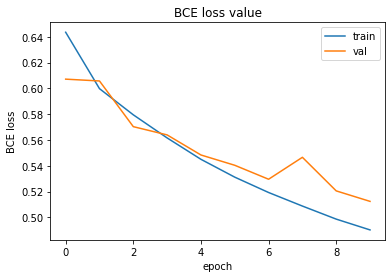

In [97]:
plt.plot(proc_losses)
plt.plot(proc_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

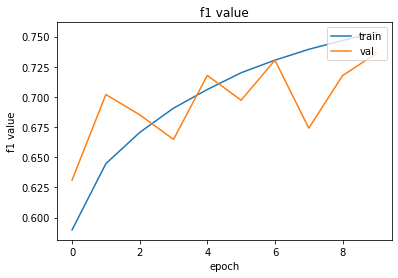

In [98]:
plt.plot(proc_f1s)
plt.plot(proc_f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [99]:
proc_fp, proc_fn, proc_tp, proc_tn = predict(proc_drop_opt_model, proc_val_iterator, proc_id2word)

In [100]:
len(proc_fp + proc_fn + proc_tp + proc_tn)

45367

In [101]:
proc_drop_opt_accuracy = len(proc_tp + proc_tn) / len(proc_fp + proc_fn + proc_tp + proc_tn)
proc_drop_opt_precision = len(proc_tp) / (len(proc_tp) + len(proc_fp))
proc_drop_opt_recall= len(proc_tp) / (len(proc_tp) + len(proc_fn))

In [ ]:
# было - бейслайн
proc_accuracy, proc_precision, proc_recall

(0.7394581964864329, 0.7504028648164727, 0.7286161335187761)

In [ ]:
# было - с дропаутом
proc_drop_accuracy, proc_drop_precision, proc_drop_recall

(0.7407366588048582, 0.7308860967397552, 0.7736439499304589)

In [102]:
# стало - с дропаутом и другим оптимайзером
proc_drop_opt_accuracy, proc_drop_opt_precision, proc_drop_opt_recall

(0.7373641633786673, 0.7501917091433984, 0.7228355354659249)

А теперь всё снова вернулось к бейслайну: незначительные ухудшения по всем трём метрикам, все улучшения от дропаута нейтрализованы((  

На этом этапе признаём лучшей моделью вариант с дропаутом и переходим ко второй архитектуре

### CNN по словам и символам

In [27]:
sym_vocab = Counter()
for text in data['text']:
    sym_vocab.update(list(text))
print('всего уникальных символов:', len(sym_vocab))

всего уникальных символов: 456


In [28]:
filtered_sym_vocab = set()

for symbol in sym_vocab:
    if sym_vocab[symbol] > 5:
        filtered_sym_vocab.add(symbol)
print('уникальных символов, вcтретившихся больше 5 раз:', len(filtered_sym_vocab))

уникальных символов, вcтретившихся больше 5 раз: 234


In [29]:
# word2id остаётся прежний,
# symbol2id делаю новый

symbol2id = {'PAD':0}

for symbol in filtered_sym_vocab:
    symbol2id[symbol] = len(symbol2id)

In [30]:
#обратный словарь
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

#### Dataset & DataLoader

In [31]:
class CombinedDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['label'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = word_tokenize(self.dataset[index])
        word_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset[index])
        sym_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return word_ids, sym_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, sym_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_sym_ids = pad_sequence(sym_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_sym_ids, y

In [32]:
second_train_dataset = CombinedDataset(train_data, word2id, symbol2id, DEVICE)
second_train_sampler = RandomSampler(second_train_dataset)
second_train_iterator = DataLoader(second_train_dataset, collate_fn = second_train_dataset.collate_fn, sampler=second_train_sampler, batch_size=1024)

In [33]:
batch = next(iter(second_train_iterator))

In [34]:
batch[0].shape

torch.Size([1024, 45])

In [35]:
# декодируем через слова
[id2word[int(i)] for i in batch[0][0]]

['Второй',
 'понедельник',
 'подряд',
 'совесть',
 'меня',
 'за',
 'то',
 ',',
 'что',
 'я',
 'не',
 'иду',
 'на',
 'мероприятие',
 'в',
 '(',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [36]:
# декодируем через символы
[id2symbol[int(i)] for i in batch[1][0]]

['В',
 'т',
 'о',
 'р',
 'о',
 'й',
 ' ',
 'п',
 'о',
 'н',
 'е',
 'д',
 'е',
 'л',
 'ь',
 'н',
 'и',
 'к',
 ' ',
 'п',
 'о',
 'д',
 'р',
 'я',
 'д',
 ' ',
 'с',
 'о',
 'в',
 'е',
 'с',
 'т',
 'ь',
 ' ',
 'с',
 'ж',
 'и',
 'р',
 'а',
 'е',
 'т',
 ' ',
 'м',
 'е',
 'н',
 'я',
 ' ',
 'з',
 'а',
 ' ',
 'т',
 'о',
 ',',
 ' ',
 'ч',
 'т',
 'о',
 ' ',
 'я',
 ' ',
 'н',
 'е',
 ' ',
 'и',
 'д',
 'у',
 ' ',
 'н',
 'а',
 ' ',
 'м',
 'е',
 'р',
 'о',
 'п',
 'р',
 'и',
 'я',
 'т',
 'и',
 'е',
 ' ',
 'в',
 ' ',
 'Д',
 'П',
 '(',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD'

In [37]:
# а это верный ответ
batch[2][0]

tensor([0.], device='cuda:0')

In [38]:
second_val_dataset = CombinedDataset(val_data, word2id, symbol2id, DEVICE)
second_val_sampler = SequentialSampler(second_val_dataset)
second_val_iterator = DataLoader(second_val_dataset, collate_fn = second_val_dataset.collate_fn, sampler=second_val_sampler, batch_size=1024)

In [39]:
test_batch = next(iter(second_val_iterator))
test_batch[0].shape

torch.Size([1024, 46])

#### Загрузка предобученных векторов

In [24]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2021-11-24 15:22:08--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  46.1MB/s    in 1.1s    

2021-11-24 15:22:10 (46.1 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [78]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [80]:
# собрать матрицу векторов в нужном порядке
ids = []
for word in word2id:
    lemma = morph.parse(word)[0].normal_form
    if lemma in navec:
        ids.append(navec.vocab[lemma])
    elif word == 'PAD':
        ids.append(navec.vocab['<pad>'])
    else:
        ids.append(navec.vocab['<unk>'])

emb = NavecEmbedding(navec)
input = torch.tensor(ids)
weights = emb(input)
weights.shape

torch.Size([33671, 300])

#### CNN2 model

In [81]:
class CNN2(nn.Module):
    
    def __init__(self, word_vocab_size, sym_vocab_size, embedding_dim):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(weights, freeze=True)
        self.mean = nn.AvgPool1d(kernel_size=2, stride=2)
        self.linear = nn.Linear(in_features=300, out_features=101)
        self.sym_embedding = nn.Embedding(sym_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=120, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.hidden = nn.Linear(in_features=301, out_features=1)
        # self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, sent_word, sent_sym):
        #batch_size x word_seq_len
        embedded_word = self.word_embedding(sent_word)
        #batch_size x word_seq_len x word_embedding_dim
        embedded_word = embedded_word.transpose(1,2)
        #batch_size x word_embedding_dim x word_seq_len
        mean_sent = embedded_word.mean(2)
        # batch_size x word_embedding_dim
        X_vector = self.linear(mean_sent)
        # batch_size x word_embedding_dim

        embedded_sym = self.sym_embedding(sent_sym)
        # batch_size x sym_seq_len x sym_embedding_dim
        embedded_sym = embedded_sym.transpose(1,2)
        #batch_size x sym_embedding_dim x sym_seq_len
        feature_map_bigrams = self.bigrams(embedded_sym)
        #batch_size x filter_count2 x sym_seq_len* 
        feature_map_trigrams = self.trigrams(embedded_sym)
        #batch_size x filter_count3 x sym_seq_len*

        pooling_bi = feature_map_bigrams.max(2)[0]
        # batch_size x filter_count2
        pooling_tri = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling_bi, pooling_tri, X_vector), 1)
        # batch_size x (filter_count2 + filter_count3 + word_embedding_dim)
        logits = self.hidden(concat)
        logits = self.out(logits)
        return logits
      
        
    

In [83]:
batch_word, batch_symbol, y = next(iter(second_train_iterator))
batch_word, batch_symbol, y = batch_word.to(device='cpu'), batch_symbol.to(device='cpu'), y.to(device='cpu')
print(batch_word)

tensor([[11312, 25382, 28216,  ...,     0,     0,     0],
        [17950,  6451, 32280,  ...,     0,     0,     0],
        [19102,  9110,  9649,  ...,     0,     0,     0],
        ...,
        [19102, 30431,  6829,  ...,     0,     0,     0],
        [19102, 17028, 11844,  ...,     0,     0,     0],
        [19102,  4168, 13948,  ...,     0,     0,     0]])


In [84]:
print(batch_symbol)

tensor([[205, 115,  66,  ...,   0,   0,   0],
        [ 20, 188, 144,  ...,   0,   0,   0],
        [ 22, 122,  99,  ...,   0,   0,   0],
        ...,
        [ 22, 165, 194,  ...,   0,   0,   0],
        [ 22, 218, 163,  ...,   0,   0,   0],
        [ 22,  28,  99,  ..., 153, 227, 119]])


In [85]:
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]])

In [86]:
model2 = CNN2(len(id2word), len(id2symbol), 20)
output = model2(batch_word, batch_symbol)
print(output)

tensor([[0.4349],
        [0.4066],
        [0.5008],
        ...,
        [0.4946],
        [0.4159],
        [0.4512]], grad_fn=<SigmoidBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


#### training loop

In [88]:
def train(model, iterator, optimizer, criterion, metric):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    epoch_metric = 0
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (batch_word, batch_symbol, ys) in enumerate(iterator): #здесь передаю индексы слова и символов отдельно
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(batch_word, batch_symbol)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric
        if not (i + 1) % 20:
            print(f'Train loss: {loss.item()}, Train f1: {batch_metric}')
            #print(f'Train loss: {epoch_loss/i}, Train f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [89]:
def evaluate(model, iterator, criterion, metric):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (batch_word, batch_symbol, ys) in enumerate(iterator):   
            preds = model(batch_word, batch_symbol)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % 20:
              print(f'Val loss: {loss.item()}, Val f1: {batch_metric}')
              #print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

Инициализируем модель, задаем оптимизатор и функцию потерь

In [92]:
model2 = CNN2(len(word2id), len(symbol2id), 20)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model2 = model2.to(DEVICE)
criterion = criterion.to(DEVICE)

#### Запуск обучения!

In [93]:
second_losses = []
second_losses_eval = []
second_f1s = []
second_f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model2, second_train_iterator, optimizer, criterion, metric=f1)
    second_losses.append(epoch_loss)
    second_f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model2, second_val_iterator, criterion, metric=f1)
    second_losses_eval.append(epoch_loss_on_test)
    second_f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train loss: 0.6227412223815918, Train f1: 0.6471278071403503
Train loss: 0.4763016104698181, Train f1: 0.9191729426383972
Train loss: 0.29055556654930115, Train f1: 0.954285740852356
Train loss: 0.14582787454128265, Train f1: 0.9848484992980957
Train loss: 0.08442117273807526, Train f1: 0.9811676144599915
Train loss: 0.0607309453189373, Train f1: 0.9826589822769165
Train loss: 0.03777296841144562, Train f1: 0.9861111044883728
Train loss: 0.032941680401563644, Train f1: 0.9922630786895752

Validating...
Val loss: 0.034615859389305115, Val f1: 0.9902344346046448
Val loss: 0.026017049327492714, Val f1: 0.993262767791748

starting Epoch 2
Training...
Train loss: 0.021573686972260475, Train f1: 0.9951503276824951
Train loss: 0.01634191907942295, Train f1: 0.9979550242424011
Train loss: 0.021863460540771484, Train f1: 0.992337167263031
Train loss: 0.01884131133556366, Train f1: 0.9934640526771545
Train loss: 0.0152808902785182, Train f1: 0.9939637780189514
Train

In [94]:
torch.save(model2, 'colab_model_2.pt')

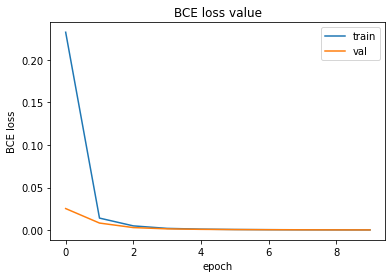

In [95]:
plt.plot(second_losses)
plt.plot(second_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

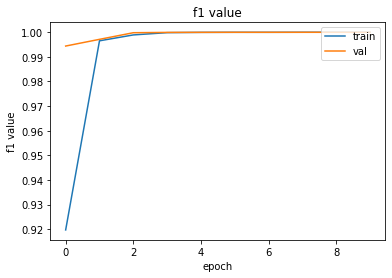

In [97]:
plt.plot(second_f1s)
plt.plot(second_f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [99]:
def predict(model, iterator, id2word):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (batch_word, batch_symbol, ys) in enumerate(iterator):   
            preds = model(batch_word, batch_symbol)  # делаем предсказания на тесте 
            for pred, gold, words in zip(preds, ys, batch_word):
              # тексты собираю только из слов
              text = ' '.join([id2word[int(word)] for word in words if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [100]:
second_fp, second_fn, second_tp, second_tn = predict(model2, second_val_iterator, id2word)

In [102]:
len(second_fp + second_fn + second_tp + second_tn)

45367

In [103]:
second_accuracy = len(second_tp + second_tn) / len(second_fp + second_fn + second_tp + second_tn)
second_precision=len(second_tp)/(len(second_tp)+len(second_fp))
second_recall=len(second_tp)/(len(second_tp)+len(second_fn))

In [104]:
second_accuracy, second_precision, second_recall

(0.9999559150924681, 0.9999564857926113, 0.9999564857926113)

В этот раз не 1.0, но почти (1.0 во всех метриках было, когда я не так подала эмбеддинги). Всего по одной ошибке в каждом классе:

In [107]:
print(second_fp)
print(second_fn)

['Сделали за и сдали . Он знает : - ! http :']
['- это надо послушать : http :']


Тут анализировать и нечего, разве что сказать, что это очень короткие твиты, которые и человеку снова сложно понять

#### То же самое, но с препроцессингом

In [108]:
proc_sym_vocab = Counter()
for text in data['preproc_text']:
    proc_sym_vocab.update(list(text))
print('всего уникальных символов:', len(proc_sym_vocab))

всего уникальных символов: 73


In [109]:
filtered_proc_sym_vocab = set()

for symbol in proc_sym_vocab:
    if proc_sym_vocab[symbol] > 5:
        filtered_proc_sym_vocab.add(symbol)
print('уникальных символов, вcтретившихся больше 5 раз:', len(filtered_proc_sym_vocab))

уникальных символов, вcтретившихся больше 5 раз: 73


In [118]:
# word2id остаётся прежний,
# symbol2id делаю новый

proc_symbol2id = {'PAD':0}

for symbol in filtered_proc_sym_vocab:
    proc_symbol2id[symbol] = len(proc_symbol2id)

In [119]:
#обратный словарь
proc_id2symbol = {i:symbol for symbol, i in proc_symbol2id.items()}

In [120]:
class ProcCombinedDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['preproc_text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['label'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = word_tokenize(self.dataset[index])
        word_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset[index])
        sym_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return word_ids, sym_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, sym_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_sym_ids = pad_sequence(sym_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_sym_ids, y

In [121]:
second_proc_train_dataset = ProcCombinedDataset(proc_train_data, proc_word2id, proc_symbol2id, DEVICE)
second_proc_train_sampler = RandomSampler(second_proc_train_dataset)
second_proc_train_iterator = DataLoader(second_proc_train_dataset, collate_fn = second_proc_train_dataset.collate_fn, sampler=second_proc_train_sampler, batch_size=1024)

In [124]:
second_proc_val_dataset = ProcCombinedDataset(proc_val_data, proc_word2id, proc_symbol2id, DEVICE)
second_proc_val_sampler = SequentialSampler(second_proc_val_dataset)
second_proc_val_iterator = DataLoader(second_proc_val_dataset, collate_fn = second_proc_val_dataset.collate_fn, sampler=second_proc_val_sampler, batch_size=1024)

In [125]:
proc_model2 = CNN2(len(proc_word2id), len(proc_symbol2id), 20)
optimizer = optim.Adam(proc_model2.parameters(), lr=0.001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
proc_model2 = proc_model2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [126]:
proc_second_losses = []
proc_second_losses_eval = []
proc_second_f1s = []
proc_second_f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(proc_model2, second_proc_train_iterator, optimizer, criterion, metric=f1)
    proc_second_losses.append(epoch_loss)
    proc_second_f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(proc_model2, second_proc_val_iterator, criterion, metric=f1)
    proc_second_losses_eval.append(epoch_loss_on_test)
    proc_second_f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train loss: 0.6747533082962036, Train f1: 0.6922529935836792
Train loss: 0.6611273288726807, Train f1: 0.6207565069198608
Train loss: 0.6350134611129761, Train f1: 0.6114100813865662
Train loss: 0.6041420698165894, Train f1: 0.6898496150970459
Train loss: 0.6145474314689636, Train f1: 0.6523076891899109
Train loss: 0.5945578813552856, Train f1: 0.6933575868606567
Train loss: 0.5859134197235107, Train f1: 0.6921606659889221
Train loss: 0.5883008241653442, Train f1: 0.6528066396713257

Validating...
Val loss: 0.5750425457954407, Val f1: 0.6948989033699036
Val loss: 0.5543248653411865, Val f1: 0.7182426452636719

starting Epoch 2
Training...
Train loss: 0.5620532035827637, Train f1: 0.7098591923713684
Train loss: 0.5563454627990723, Train f1: 0.7531083822250366
Train loss: 0.546256959438324, Train f1: 0.7264325618743896
Train loss: 0.5518841743469238, Train f1: 0.6718749403953552
Train loss: 0.5515800714492798, Train f1: 0.7152317762374878
Train loss: 0.55333

In [127]:
torch.save(model2, 'colab_proc_model_2.pt')

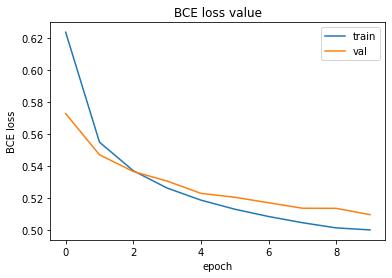

In [128]:
plt.plot(proc_second_losses)
plt.plot(proc_second_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

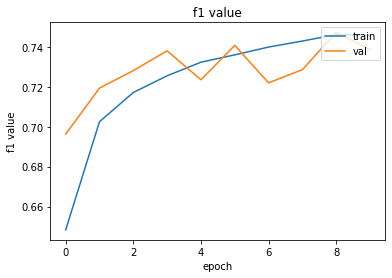

In [129]:
plt.plot(proc_second_f1s)
plt.plot(proc_second_f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [130]:
proc_fp2, proc_fn2, proc_tp2, proc_tn2 = predict(proc_model2, second_proc_val_iterator, proc_id2word)

In [131]:
len(proc_fp2 + proc_fn2 + proc_tp2 + proc_tn2)

45367

In [132]:
proc_accuracy2 = len(proc_tp2 + proc_tn2) / len(proc_fp2 + proc_fn2 + proc_tp2 + proc_tn2)
proc_precision2=len(proc_tp2)/(len(proc_tp2)+len(proc_fp2))
proc_recall2=len(proc_tp2)/(len(proc_tp2)+len(proc_fn2))

In [134]:
proc_accuracy2, proc_precision2, proc_recall2

(0.7393479842176031, 0.7487053571428571, 0.7302216223276875)

Метрики ожидаемо ухудшились. Посмотрим поближе

In [136]:
len(proc_fn2), len(proc_fp2)

(6196, 5629)

#### Анализ предсказаний

In [142]:
print('Позитивные твиты, предсказанные как негативные:\n')
for tweet in sample(proc_fn2, 20):
  print(tweet)

Позитивные твиты, предсказанные как негативные:

rt USER USER не замечала прости да я тоже волк одиночка
rt USER против URL
где то уже я подобный блок питания уже видел только в белом pc asus apple power URL
что можно подарить другу на 23 февраля недорого мысли в комменты
USER разрешила и будет это вещи настолько что даже обсуждать не хочется
сами небеса послали к нам на замену на к р по биологии
несомненно зеленых или синих не будет явно детей
USER 5 грамм та ба ой
USER URL не основной да
началось около 12 часов с с молочком и лекции по культуре
USER не я не смогу общаться сразу с двумя если они только не будут тоже а они не будут моя бывшая очень ебанутая
друзья помогите пожалуйста я до жути хочу этот но я пожалуйста помогите URL
и деньги
поэтому не буду и сегодня ничего жрать только чаек только хардкор
USER USER USER а вы боялись
ураааа снег наконец так весело мине еще никогда не было
а некоторые уже сейчас сидят на первом с руками а у некоторых оно завтра ребята вы
оля забацала рас

In [141]:
print('Негативные твиты, предсказанные как позитивные:\n')

for tweet in sample(proc_fp2, 20):
  print(tweet)

Негативные твиты, предсказанные как позитивные:

USER ой блин мне тоже надо спасибо что напомнила d
думала меня до в итоге машина не завелась ждали
rt USER USER yes если что пиши на счет сериала буду рада тебе lt 3
USER хахахха вообще обнаглела ужасно так фууу такой быть
rt USER умер директор 57 гимназии светлая память вам валентина
USER сегодня увидела парня который был похож на не увидела того парня ахахах
rt USER USER это ты злой злой человек
USER сказали лучше коктейли делать
халявные тесты от english first и прочие у меня 88 по английскому URL
без всяких понтов или других причин почему мало кто любит за за душу
USER моде попробовать записать разговор и в
USER приглашаю тебя на мою свадьбу сегодня в 2 по мск буду рад видеть 333
USER ах ты лень любимому из бумаги какую нибудь сделать
rt USER слезы в глазах течет как река течет по щекам разрывая сердце URL
о чем сегодня я пропустил по причине
сегодня первый раз за эту зиму сходили на каток как то не очень для первого раза
rt USER сна

Здесь в принципе справедливо всё то же, что было сказано при анализе первой архитектуры без пунктуации: предложения неоднозначные, эталонная разметка путающая, без смайликов информации о тональности почти не остаётся. Не могу сказать, что это прям очень серьёзные ошибки, и я уверена, что если этой или улучшенной архитектуре подать более чистые данные, то результат будет около 0.9 даже с предобработкой  
(эх, умела бы я такое на третьем курсе, когда делала курсовую про распознавание иронии на своём ручном чистеньком причёсанном корпусе комментариев)

#### Улучшение модели

##### Нелинейность
Может быть, добавление ReLU поможет улучшить результаты?

In [143]:
class CNN2_nonlin(nn.Module):
    
    def __init__(self, word_vocab_size, sym_vocab_size, embedding_dim):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(weights, freeze=True)
        self.mean = nn.AvgPool1d(kernel_size=2, stride=2)
        self.linear = nn.Linear(in_features=300, out_features=101)
        self.sym_embedding = nn.Embedding(sym_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=120, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=301, out_features=1)
        # self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, sent_word, sent_sym):
        #batch_size x word_seq_len
        embedded_word = self.word_embedding(sent_word)
        #batch_size x word_seq_len x word_embedding_dim
        embedded_word = embedded_word.transpose(1,2)
        #batch_size x word_embedding_dim x word_seq_len
        mean_sent = embedded_word.mean(2)
        # batch_size x word_embedding_dim
        X_vector = self.linear(mean_sent)
        # batch_size x word_embedding_dim

        embedded_sym = self.sym_embedding(sent_sym)
        # batch_size x sym_seq_len x sym_embedding_dim
        embedded_sym = embedded_sym.transpose(1,2)
        #batch_size x sym_embedding_dim x sym_seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded_sym))
        #batch_size x filter_count2 x sym_seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded_sym))
        #batch_size x filter_count3 x sym_seq_len*

        pooling_bi = feature_map_bigrams.max(2)[0]
        # batch_size x filter_count2
        pooling_tri = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling_bi, pooling_tri, X_vector), 1)
        # batch_size x (filter_count2 + filter_count3 + word_embedding_dim)
        logits = self.hidden(concat)
        logits = self.out(logits)
        return logits
      
        
    

In [144]:
proc_nonlin_model2 = CNN2_nonlin(len(proc_word2id), len(proc_symbol2id), 20)
optimizer = optim.Adam(proc_nonlin_model2.parameters(), lr=0.001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
proc_nonlin_model2 = proc_nonlin_model2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [146]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(proc_nonlin_model2, second_proc_train_iterator, optimizer, criterion, metric=f1)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(proc_nonlin_model2, second_proc_val_iterator, criterion, metric=f1)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train loss: 0.6761540174484253, Train f1: 0.5180022716522217
Train loss: 0.6549133062362671, Train f1: 0.6635859608650208
Train loss: 0.6297825574874878, Train f1: 0.6612576246261597
Train loss: 0.6295289397239685, Train f1: 0.6672844886779785
Train loss: 0.6035825610160828, Train f1: 0.6338330507278442
Train loss: 0.6111111640930176, Train f1: 0.6455566883087158
Train loss: 0.5969869494438171, Train f1: 0.678537905216217
Train loss: 0.6037411689758301, Train f1: 0.7099035978317261

Validating...
Val loss: 0.5799379348754883, Val f1: 0.6405919790267944
Val loss: 0.56717848777771, Val f1: 0.654347836971283

starting Epoch 2
Training...
Train loss: 0.568015992641449, Train f1: 0.7005870342254639
Train loss: 0.5619759559631348, Train f1: 0.6818181872367859
Train loss: 0.5751779675483704, Train f1: 0.6576763391494751
Train loss: 0.5717271566390991, Train f1: 0.7185520529747009
Train loss: 0.5433754324913025, Train f1: 0.6812499761581421
Train loss: 0.555553197

In [154]:
torch.save(proc_nonlin_model2, 'colab_proc_nonlin_model_2.pt')

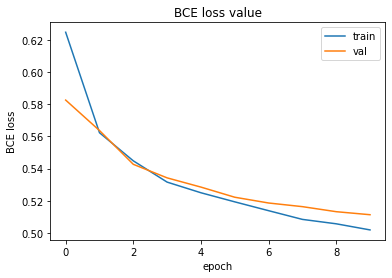

In [148]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

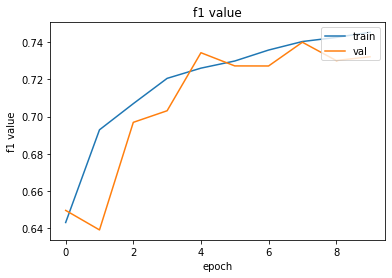

In [149]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [150]:
proc_nonlin_fp2, proc_nonlin_fn2, proc_nonlin_tp2, proc_nonlin_tn2 = predict(proc_nonlin_model2, second_proc_val_iterator, proc_id2word)

In [151]:
proc_nonlin_accuracy2 = len(proc_nonlin_tp2 + proc_nonlin_tn2) / len(proc_nonlin_fp2 + proc_nonlin_fn2 + proc_nonlin_tp2 + proc_nonlin_tn2)
proc_nonlin_precision2=len(proc_nonlin_tp2)/(len(proc_nonlin_tp2)+len(proc_nonlin_fp2))
proc_nonlin_recall2=len(proc_nonlin_tp2)/(len(proc_nonlin_tp2)+len(proc_nonlin_fn2))

In [ ]:
# было
proc_accuracy2, proc_precision2, proc_recall2

(0.7393479842176031, 0.7487053571428571, 0.7302216223276875)

In [152]:
# стало
proc_nonlin_accuracy2, proc_nonlin_precision2, proc_nonlin_recall2

(0.7354464699010294, 0.7505827505827506, 0.7150259067357513)

Доля верных ответов и полноста снизились, а точность выросла. В целом модель стала чуть менее "сбалансированной" и даёт больше ложноположительных ответов, чем до добавления нелинейности, когда точность и полнота были не настолько разные  
Интерпретация этих изменений как хороших или плохих зависит от конкретной цели: важнее ли нам найти все хорошие или не перепутать с ними плохие. В нашем случае цель не задана, поэтому я сама решу, что улучшение точности с ухудшением аккураси и полноты - так себе улучшение. Второе улучшение протестирую без релу

##### Размер фильтров
Что если поменять out_channels и out_features?

In [155]:
class CNN2_filt(nn.Module):
    
    def __init__(self, word_vocab_size, sym_vocab_size, embedding_dim):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(weights, freeze=True)
        self.linear = nn.Linear(in_features=300, out_features=150)
        self.sym_embedding = nn.Embedding(sym_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=160, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=160, kernel_size=3, padding='same')
        self.hidden = nn.Linear(in_features=470, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, sent_word, sent_sym):
        #batch_size x word_seq_len
        embedded_word = self.word_embedding(sent_word)
        #batch_size x word_seq_len x word_embedding_dim
        embedded_word = embedded_word.transpose(1,2)
        #batch_size x word_embedding_dim x word_seq_len
        mean_sent = embedded_word.mean(2)
        # batch_size x word_embedding_dim
        X_vector = self.linear(mean_sent)
        # batch_size x word_embedding_dim

        embedded_sym = self.sym_embedding(sent_sym)
        # batch_size x sym_seq_len x sym_embedding_dim
        embedded_sym = embedded_sym.transpose(1,2)
        #batch_size x sym_embedding_dim x sym_seq_len
        feature_map_bigrams = self.bigrams(embedded_sym)
        #batch_size x filter_count2 x sym_seq_len* 
        feature_map_trigrams = self.trigrams(embedded_sym)
        #batch_size x filter_count3 x sym_seq_len*

        pooling_bi = feature_map_bigrams.max(2)[0]
        # batch_size x filter_count2
        pooling_tri = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling_bi, pooling_tri, X_vector), 1)
        # batch_size x (filter_count2 + filter_count3 + word_embedding_dim)
        logits = self.hidden(concat)
        logits = self.out(logits)
        return logits
      
        
    

In [156]:
proc_filt_model2 = CNN2_filt(len(proc_word2id), len(proc_symbol2id), 20)
optimizer = optim.Adam(proc_filt_model2.parameters(), lr=0.001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
proc_filt_model2 = proc_filt_model2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [157]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(proc_filt_model2, second_proc_train_iterator, optimizer, criterion, metric=f1)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(proc_filt_model2, second_proc_val_iterator, criterion, metric=f1)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train loss: 0.6624414324760437, Train f1: 0.6454545259475708
Train loss: 0.6508981585502625, Train f1: 0.6214355826377869
Train loss: 0.6184325218200684, Train f1: 0.6534091234207153
Train loss: 0.6103230714797974, Train f1: 0.67119300365448
Train loss: 0.6031116247177124, Train f1: 0.7186440825462341
Train loss: 0.5821670293807983, Train f1: 0.7216312289237976
Train loss: 0.569878101348877, Train f1: 0.6745182275772095
Train loss: 0.5700631737709045, Train f1: 0.7007874250411987

Validating...
Val loss: 0.566509485244751, Val f1: 0.6780684590339661
Val loss: 0.5492035150527954, Val f1: 0.6960082054138184

starting Epoch 2
Training...
Train loss: 0.5610541105270386, Train f1: 0.7312775254249573
Train loss: 0.5648126602172852, Train f1: 0.6957404017448425
Train loss: 0.5627846717834473, Train f1: 0.7333908081054688
Train loss: 0.5488772392272949, Train f1: 0.7110228538513184
Train loss: 0.5576108694076538, Train f1: 0.6702470779418945
Train loss: 0.54865056

In [ ]:
torch.save(proc_filt_model2, 'colab_proc_filt_model_2.pt')

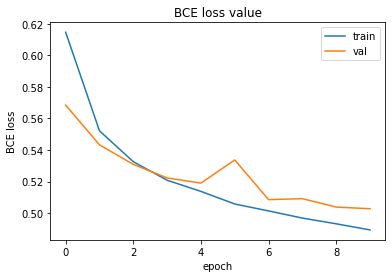

In [158]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

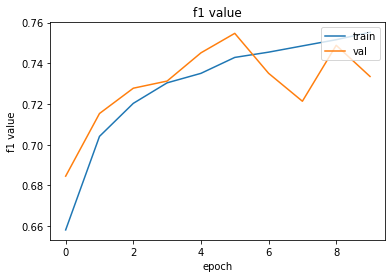

In [159]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [160]:
proc_filt_fp2, proc_filt_fn2, proc_filt_tp2, proc_filt_tn2 = predict(proc_filt_model2, second_proc_val_iterator, proc_id2word)

In [161]:
proc_filt_accuracy2 = len(proc_filt_tp2 + proc_filt_tn2) / len(proc_filt_fp2 + proc_filt_fn2 + proc_filt_tp2 + proc_filt_tn2)
proc_filt_precision2=len(proc_filt_tp2)/(len(proc_filt_tp2)+len(proc_filt_fp2))
proc_filt_recall2=len(proc_filt_tp2)/(len(proc_filt_tp2)+len(proc_filt_fn2))

In [ ]:
# было
proc_accuracy2, proc_precision2, proc_recall2

(0.7393479842176031, 0.7487053571428571, 0.7302216223276875)

In [ ]:
# было - с нелинейностью
proc_nonlin_accuracy2, proc_nonlin_precision2, proc_nonlin_recall2

(0.7354464699010294, 0.7505827505827506, 0.7150259067357513)

In [162]:
# стало с другими размерностями
proc_filt_accuracy2, proc_filt_precision2, proc_filt_recall2

(0.7437123900632618, 0.774390243902439, 0.6967387991466016)

Успех!  
По сравнению с первым вариантом, выросли общая доля верных ответов и точность, хоть и снизилась полнота. В отличие от предыдущего эксепримента, я считаю это успехом, потому что не только точность-полнота поменялись - одна в плюс, другая в минус - но и выросла accuracy